### Additional Physical Activity Metrics - ENMO (Euclidean norm minus one )

Accelerometer / scaling / ENMO

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "/Users/leasaab/Documents/Dev/AX3-Project/data/FemmeCardio.csv"

data = pd.read_csv(file_path)

timestamp_column = data.columns[0]
signal_columns = data.columns[1:]   # All remaining columns are sensor data

# Convert the timestamp column to datetime
data[timestamp_column] = pd.to_datetime(data[timestamp_column], errors='coerce')  # Handle invalid dates

# Calculate the sampling interval (in seconds)
sampling_interval = (
    pd.to_datetime(data[timestamp_column].iloc[1]) -  # Access a single row
    pd.to_datetime(data[timestamp_column].iloc[0])
).total_seconds()

# Create a relative time axis (in minutes)
data['relative_time_minutes'] = data.index * sampling_interval

# Define axis labels for clarity
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
colors = {'X': 'blue', 'Y': 'red', 'Z': 'green'}  # Define colors for each signal

### Correction du décalage pour recentrer les moyennes autour de 1g pour l’axe vertical (Z), et 0g pour les autres axes. Puis appliquer un filtre passe-bas:

In [21]:
calibration_offset = {
    '-0.296875': -1.62,   # Offset pour l'axe X
    '0.703125': -0.88,    # Offset pour l'axe Y
    '-0.343750': -1.16    # Offset pour l'axe Z
}
for col, offset in calibration_offset.items():
    data[col] = data[col] - offset

from scipy.signal import butter, filtfilt

# Function to apply a low-pass filter
def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter.
    
    Parameters:
        data (array-like): The signal to filter.
        cutoff (float): The cutoff frequency in Hz.
        fs (float): The sampling frequency in Hz.
        order (int): The order of the filter (default is 4).
    
    Returns:
        array-like: The filtered signal.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

fs = 1 / sampling_interval  # Fréquence d'échantillonnage en Hz
cutoff = 2  # Fréquence de coupure en Hz
for col in signal_columns:
    data[col] = lowpass_filter(data[col], cutoff, fs)

   relative_time_minutes  ENMO
0                  0.000   0.0
1                  0.002   0.0
2                  0.004   0.0
3                  0.006   0.0
4                  0.008   0.0


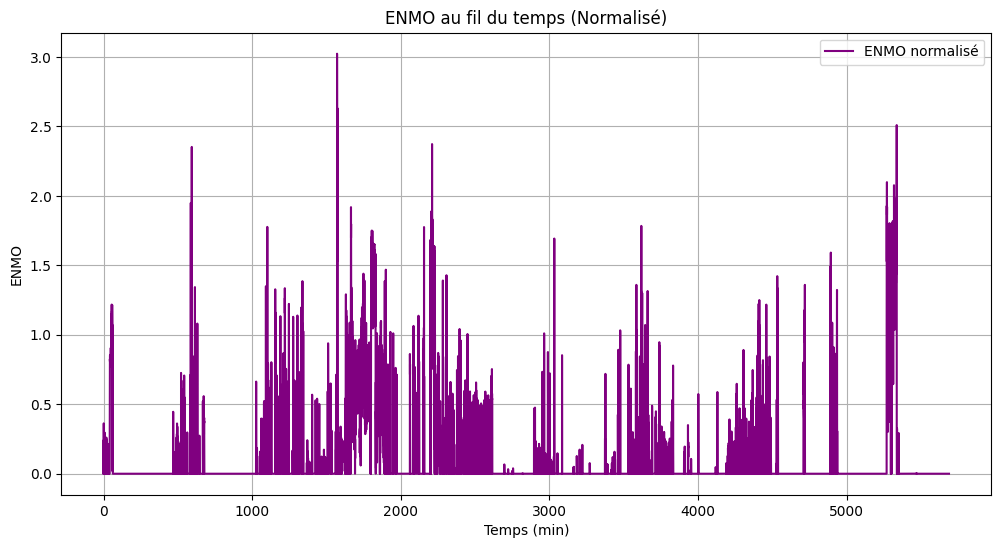

In [23]:
import numpy as np

# Calcul de la norme euclidienne des accélérations (X, Y, Z)
data.loc[:, 'norm'] = np.sqrt(data['-0.296875']**2 + data['0.703125']**2 + data['-0.343750']**2)

# Normalisation : centrer et réduire les données
mean_norm = data['norm'].mean()
std_norm = data['norm'].std()
data.loc[:, 'norm_normalized'] = (data['norm'] - mean_norm) / std_norm

# Calcul de l'ENMO : norme normalisée - 1, et on garde la valeur maximale entre 0 et la norme
data.loc[:, 'ENMO'] = np.maximum(data['norm_normalized'] - 1, 0)

# Affichage des premiers résultats
print(data[['relative_time_minutes', 'ENMO']].head())

# Visualisation de l'ENMO normalisé
plt.figure(figsize=(12, 6))
plt.plot(data['relative_time_minutes'], data['ENMO'], label="ENMO normalisé", color='purple')
plt.title("ENMO au fil du temps (Normalisé)")
plt.xlabel("Temps (min)")
plt.ylabel("ENMO")
plt.legend()
plt.grid(True)
plt.show()

1. Analyse des plages d’intensité

Activités faibles ou inactives (trajet) :
- Généralement avec un ENMO très bas (< 0.1).
Ces moments peuvent être exclus de l’analyse principale pour mieux différencier les efforts modérés et intenses.

Activités modérées (marche rapide) :
- ENMO typique : entre 0.5 et 1.5.
Cela couvre la plage de marche rapide.

Activités intenses (sprint) :
- ENMO typique : entre 1.5 et 3.0.

2. Seuils choisis:

Pour distinguer clairement les trois types d’effort:
	1.	ENMO ≤ 0.5 : Activités faibles ou inactives (à exclure de l’analyse principale).
	2.	0.5 < ENMO ≤ 1.5 : Activités modérées (marche rapide).
	3.	ENMO > 1.5 : Activités intenses (sprint).



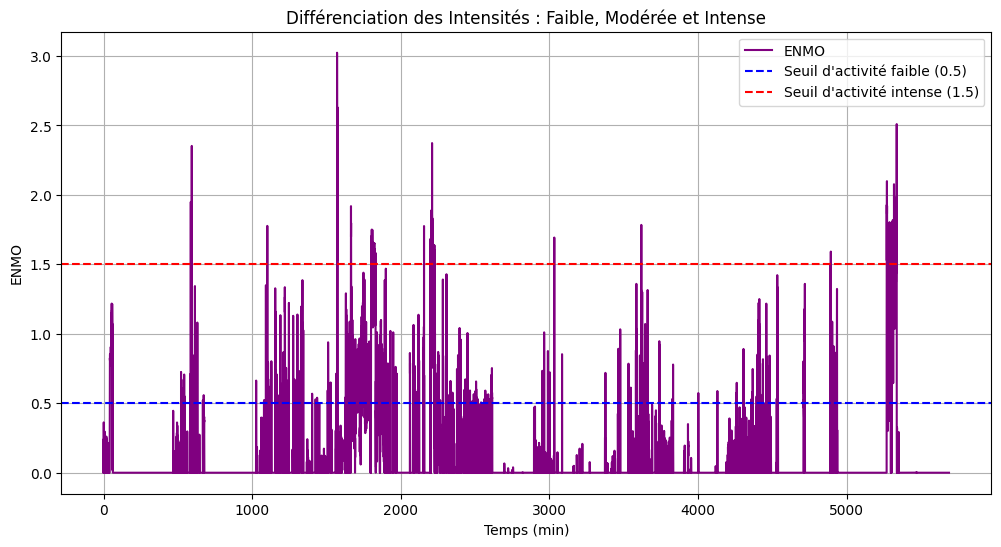

In [24]:
# Définir les seuils pour les intensités
seuil_faible = 0.5
seuil_intense = 1.5

# Classifier les moments d'intensité
moments_faibles = data[data['ENMO'] <= seuil_faible]
moments_moderes = data[(data['ENMO'] > seuil_faible) & (data['ENMO'] <= seuil_intense)]
moments_intenses = data[data['ENMO'] > seuil_intense]

# Visualisation des intensités
plt.figure(figsize=(12, 6))
plt.plot(data['relative_time_minutes'], data['ENMO'], label="ENMO", color='purple')
plt.axhline(y=seuil_faible, color='blue', linestyle='--', label="Seuil d'activité faible (0.5)")
plt.axhline(y=seuil_intense, color='red', linestyle='--', label="Seuil d'activité intense (1.5)")
plt.title("Différenciation des Intensités : Faible, Modérée et Intense")
plt.xlabel("Temps (min)")
plt.ylabel("ENMO")
plt.legend()
plt.grid(True)
plt.show()

Calcul des statistiques descriptives comme la moyenne, la médiane ou les écarts-types pour mieux comprendre la distribution de l'ENMO

In [25]:
# Statistiques de base
stats = data['ENMO'].describe()
print(stats)

count    2.844599e+06
mean     9.728115e-02
std      2.804413e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.023497e+00
Name: ENMO, dtype: float64
